In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [63]:
# ===========================================
# Setup
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [64]:
T = 50      # sequence length
tau = 5     # lag
d_model = 4
n_heads = 2
n_steps = 2000
batch_size = 128

In [65]:
# ===========================================
# Synthetic Data Generator
# ===========================================
def generate_batch(batch_size, T, tau, obs_noise=0.05):
    """
    Generate paired behavior (beh) and neural (neu) data.
    neu has two channels:
      - Channel 0: behavior lagged forward by tau  (causal)
      - Channel 1: behavior lagged backward by tau (acausal)
    """
    beh = torch.randn(batch_size, T)

    # Forward-lagged: neural follows behavior (beh -> neu)
    neu_forward = torch.roll(beh, shifts=tau, dims=1)
    neu_forward[:, :tau] = 0.0  # zero-pad the start

    # Backward-lagged: neural precedes behavior (neu -> beh)
    neu_backward = torch.roll(beh, shifts=-tau, dims=1)
    neu_backward[:, -tau:] = 0.0  # zero-pad the end

    # Stack into two channels: [B, T, 2]
    neu = torch.stack([neu_forward, neu_backward], dim=-1)

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)

    # Behavior remains single-channel: [B, T, 1]
    beh = beh.unsqueeze(-1)

    return beh, neu

In [66]:
# ===========================================
# Synthetic Data Generator with Random Temporal Flipping
# ===========================================
def generate_batch(batch_size, T, tau, obs_noise=0.05, flip_prob=0.5):
    """
    Generate paired behavior (beh) and neural (neu) data.
    neu has two channels:
      - Channel 0: behavior lagged forward by tau  (causal)
      - Channel 1: behavior lagged backward by tau (acausal)

    With probability flip_prob, the entire sequence is time-reversed
    (so "past" and "future" swap places).
    This preserves causal structure but removes consistent directionality.
    """

    beh = torch.randn(batch_size, T)

    # Forward-lagged: neural follows behavior (beh -> neu)
    neu_forward = torch.roll(beh, shifts=tau, dims=1)
    neu_forward[:, :tau] = 0.0  # zero-pad the start

    # Backward-lagged: neural precedes behavior (neu -> beh)
    neu_backward = torch.roll(beh, shifts=-tau, dims=1)
    neu_backward[:, -tau:] = 0.0  # zero-pad the end

    # Stack into two channels: [B, T, 2]
    neu = torch.stack([neu_forward, neu_backward], dim=-1)

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)

    # Behavior remains single-channel: [B, T, 1]
    beh = beh.unsqueeze(-1)

    # --------------------------------------------
    # Random temporal flipping (time reversal)
    # --------------------------------------------
    flip_mask = torch.rand(batch_size) < flip_prob
    for i in range(batch_size):
        if flip_mask[i]:
            beh[i] = torch.flip(beh[i], dims=[0])
            neu[i] = torch.flip(neu[i], dims=[0])

    # reverse_causality_prob=0.3
    # reverse_mask = torch.rand(batch_size) < reverse_causality_prob
    # for i in range(batch_size):
    #     if reverse_mask[i]:
    #         # Swap roles: now neural drives behavior
    #         beh[i, :, 0] = torch.roll(neu[i, :, 0], shifts=tau, dims=0)
    #         beh[i, :tau, 0] = 0.0

    return beh, neu

In [67]:
# ===========================================
# Positional Encoding
# ===========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncoding(d_model).to(device)

In [68]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class BiXLagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(1, d_model)
        self.in_proj_neu = nn.Linear(2, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.out_neu_proj = nn.Linear(2 * d_model, 2)
        self.out_beh_proj = nn.Linear(2 * d_model, 1)

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        B, T_dec, _ = y_emb.shape
        T_enc = x_emb.shape[1]
        device = y_emb.device

        # ------------------------------------------------
        # Build attention masks
        # ------------------------------------------------
        mask_causal = torch.triu(torch.ones(T_dec, T_enc, device=device), diagonal=1).bool()
        mask_acausal = torch.tril(torch.ones(T_dec, T_enc, device=device), diagonal=-1).bool()

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_causal,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_acausal,
            need_weights=True,
            average_attn_weights=False
        )

        # Concatenate outputs and attention weights
        attn_out = torch.cat([out_causal, out_acausal], dim=-1)
        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension

        out_neu = self.out_neu_proj(attn_out)
        out_beh = self.out_beh_proj(attn_out)

        return out_neu, out_beh, attn_weights, attn_out

In [69]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class LagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(1, d_model)
        self.in_proj_neu = nn.Linear(2, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.out_neu_proj = nn.Linear(2 * d_model, 2)
        self.out_beh_proj = nn.Linear(2 * d_model, 1)

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        B, T_dec, _ = y_emb.shape
        T_enc = x_emb.shape[1]
        device = y_emb.device

        # ------------------------------------------------
        # Build attention masks
        # ------------------------------------------------
        mask_causal = torch.triu(torch.ones(T_dec, T_enc, device=device), diagonal=1).bool()
        mask_acausal = torch.tril(torch.ones(T_dec, T_enc, device=device), diagonal=-1).bool()

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        # Concatenate outputs and attention weights
        attn_out = torch.cat([out_causal, out_acausal], dim=-1)
        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension

        out_neu = self.out_neu_proj(attn_out)
        out_beh = self.out_beh_proj(attn_out)

        return out_neu, out_beh, attn_weights, attn_out

In [70]:
# instantiate / train as usual
model = BiXLagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [71]:
# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.892794
Step 1000/2000, Loss: 0.798008
Step 1500/2000, Loss: 0.812840
Step 2000/2000, Loss: 0.779557


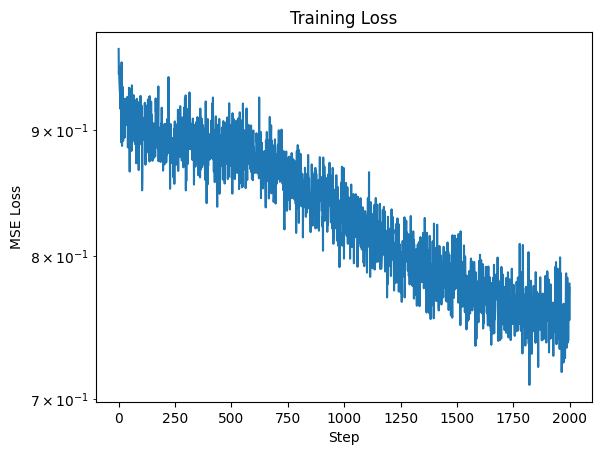

In [72]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [73]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, attn_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 50, 50])

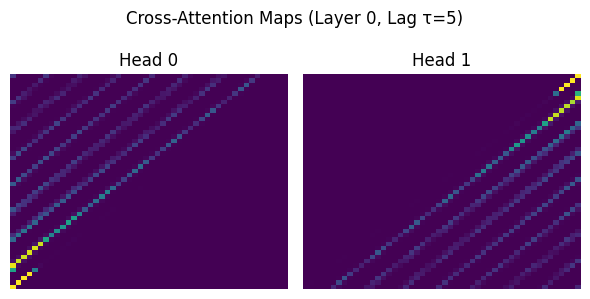

In [74]:
import math

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    plt.subplot(rows, cols, h + 1)
    plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Head {h}')
    plt.axis('off')

plt.suptitle(f'Cross-Attention Maps (Layer 0, Lag τ={tau})')
plt.tight_layout()
plt.show()

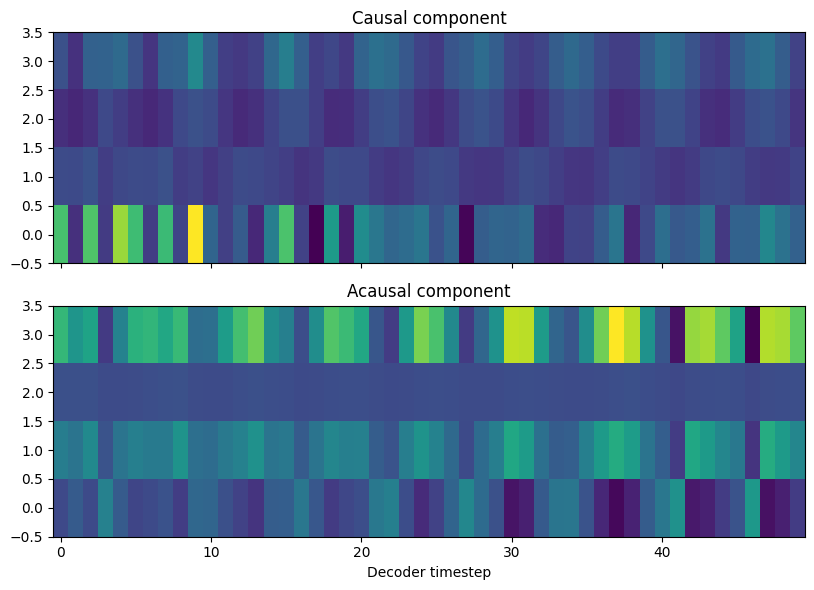

In [75]:
B, T, D2 = attn_out.shape
D = D2 // 2
causal_out = attn_out[0, :, :D]
acausal_out = attn_out[0, :, D:]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
ax[0].imshow(causal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title("Causal component")
ax[1].imshow(acausal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title("Acausal component")
ax[1].set_xlabel("Decoder timestep")
plt.tight_layout()
plt.show()

In [76]:
# instantiate / train as usual
model = LagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [77]:
# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.889122
Step 1000/2000, Loss: 0.886692
Step 1500/2000, Loss: 0.864045
Step 2000/2000, Loss: 0.885288


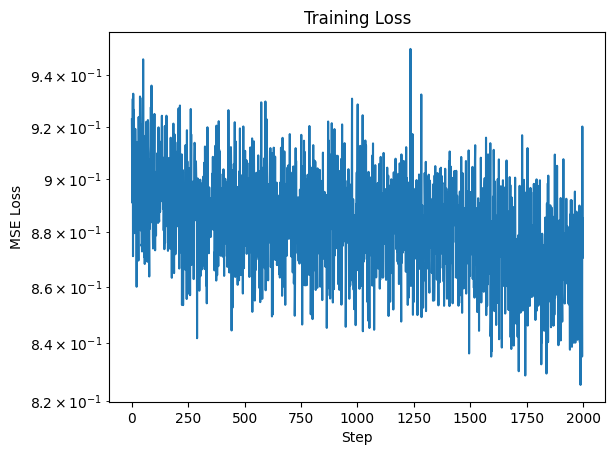

In [78]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [79]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, attn_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 50, 50])

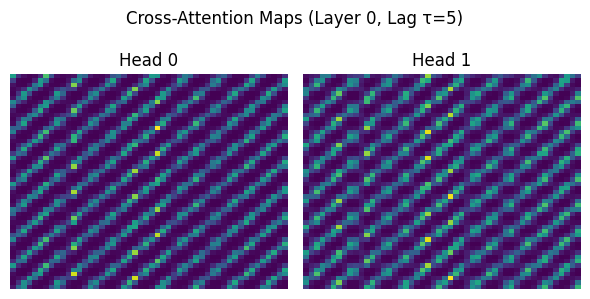

In [80]:
import math

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    plt.subplot(rows, cols, h + 1)
    plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Head {h}')
    plt.axis('off')

plt.suptitle(f'Cross-Attention Maps (Layer 0, Lag τ={tau})')
plt.tight_layout()
plt.show()

In [81]:
attn_out.shape

torch.Size([1, 50, 8])

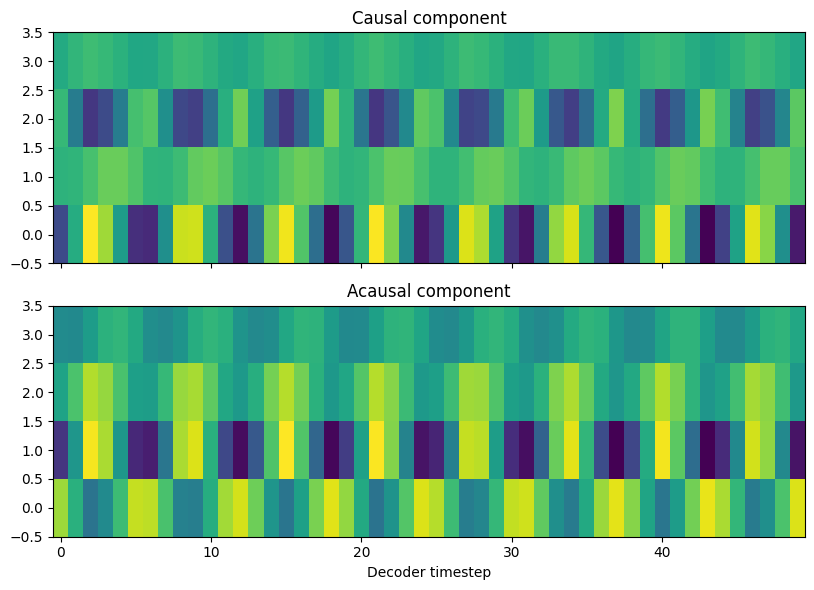

In [82]:
B, T, D2 = attn_out.shape
D = D2 // 2
causal_out = attn_out[0, :, :D]
acausal_out = attn_out[0, :, D:]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
ax[0].imshow(causal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title("Causal component")
ax[1].imshow(acausal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title("Acausal component")
ax[1].set_xlabel("Decoder timestep")
plt.tight_layout()
plt.show()